# Custom Estimator

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 8
PARAMS = dict(
    n_estimators = 300,
    random_state = RANDOM_SEED, 
    n_jobs = -1
)

In [2]:
import numpy as np
import pandas as pd
import time
import math
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Scoring Function

In [3]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, target_bins)):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        train_weight, valid_weight = train['sample_weight'].iloc[train_idx], train['sample_weight'].iloc[valid_idx]
    
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        try:
            model.fit(X_train, y_train, sample_weight = train_weight)
        except:
            model.fit(X_train, y_train)
        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds, sample_weight = valid_weight)
        oof_preds[valid_idx] = valid_preds.flatten()
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
    mask1, mask10 = train.gcd == 1, train.gcd == 10 
    mask1000, mask10000 = train.gcd == 1000, train.gcd == 10000
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[mask1], train['target'].loc[mask1], sample_weight = train['sample_weight'].loc[mask1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[mask10], train['target'].loc[mask10], sample_weight = train['sample_weight'].loc[mask10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[mask1000], train['target'].loc[mask1000], sample_weight = train['sample_weight'].loc[mask1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[mask10000], train['target'].loc[mask10000], sample_weight = train['sample_weight'].loc[mask10000]), 5))
    print("Out-of-Fold Accuracy:", round(accuracy_score(oof_preds, train['target'], sample_weight = train['sample_weight']), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from math import factorial

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)


# Plot confusion matrix
def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [5]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]

encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])
target_bins = train['target'].astype(str) + train['gcd'].astype(str)

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 1.11 s
Wall time: 194 ms


# Custom Estimator

In [6]:
from sklearn.base import BaseEstimator

class GCDEstimator(BaseEstimator):
    
    def __init__(self):
        self.model1 = ExtraTreesClassifier(**PARAMS)
        self.model2 = ExtraTreesClassifier(**PARAMS)
        self.model3 = ExtraTreesClassifier(**PARAMS)
        self.model4 = ExtraTreesClassifier(**PARAMS) 
    
    def gcd_of_all(self, df_i):
        features = [x for x in df_i.columns]
        gcd = df_i[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, df_i[col])
        self.gcd1 = (gcd == 1)
        self.gcd2 = (gcd == 10)
        self.gcd3 = (gcd == 1000)
        self.gcd4 = (gcd == 10000)
        
    def get_histograms(self, input_df):
        return pd.DataFrame({
            col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
    def fit(self, X, y, sample_weight):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        self.num_labels = len(np.unique(y))
        self.model1.fit(X[self.gcd1], y[self.gcd1], sample_weight[self.gcd1])
        self.model2.fit(X[self.gcd2], y[self.gcd2], sample_weight[self.gcd2])
        self.model3.fit(X[self.gcd3], y[self.gcd3], sample_weight[self.gcd3])
        self.model4.fit(X[self.gcd4], y[self.gcd4], sample_weight[self.gcd4])
        
    def predict_proba(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),self.num_labels))
        temp[self.gcd1] = self.model1.predict_proba(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict_proba(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict_proba(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict_proba(X[self.gcd4])
        return temp
        
    def predict(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),))
        temp[self.gcd1] = self.model1.predict(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict(X[self.gcd4])
        return temp.astype(int)

# ExtraTrees Baseline


Fold 0: 0.95691 accuracy in 20.48s.
Fold 1: 0.95479 accuracy in 20.38s.
Fold 2: 0.95453 accuracy in 20.88s.
Fold 3: 0.95796 accuracy in 22.1s.
Fold 4: 0.95603 accuracy in 20.35s.
Fold 5: 0.95466 accuracy in 20.52s.
Fold 6: 0.9538 accuracy in 20.43s.
Fold 7: 0.95467 accuracy in 20.35s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99998
Accuracy (1k Reads): 0.92145
Accuracy (100 Reads): 0.90028
Out-of-Fold Accuracy: 0.95542
Training Time: 165.5s


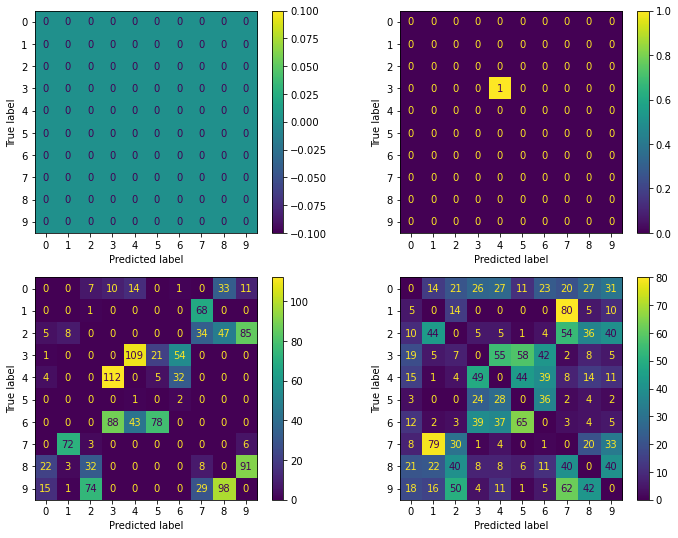

In [7]:
oof_preds = score_model(
    ExtraTreesClassifier(**PARAMS)
)

plot_confusion_matrix(train['target'],oof_preds, train['gcd'])

# Custom Estimator


Fold 0: 0.95791 accuracy in 10.05s.
Fold 1: 0.95334 accuracy in 10.45s.
Fold 2: 0.95469 accuracy in 10.67s.
Fold 3: 0.95572 accuracy in 10.38s.
Fold 4: 0.95619 accuracy in 10.7s.
Fold 5: 0.95462 accuracy in 10.64s.
Fold 6: 0.9542 accuracy in 10.21s.
Fold 7: 0.95322 accuracy in 10.23s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.91903
Accuracy (100 Reads): 0.90096
Out-of-Fold Accuracy: 0.95499
Training Time: 83.33s


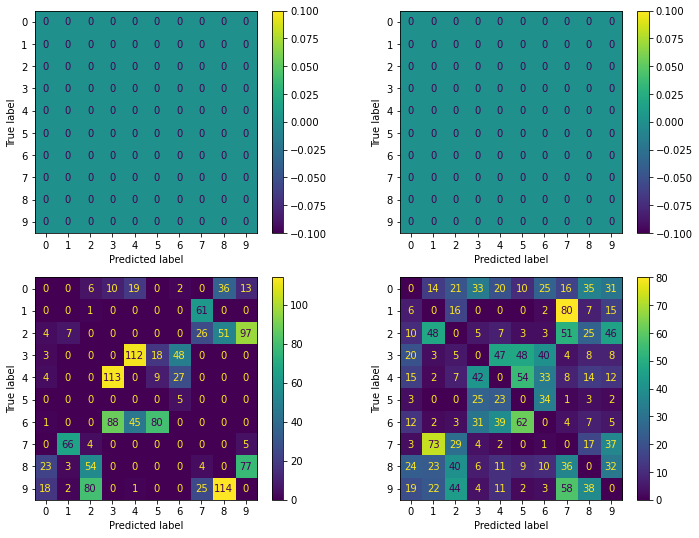

In [10]:
oof_preds = score_model(GCDEstimator())

plot_confusion_matrix(train['target'], oof_preds, train['gcd'])